# Classification of patients

At the moment, erysipelas are the 4th most common in the world among infectious diseases and, in most cases, can be cured. The main symptoms of this disease are fever, pressure, palpitations, headaches, loss of sleep and appetite. Therefore, it is proposed to develop a machine learning model that, based on these symptoms, is able to evaluate the effectiveness of treatment and, if necessary, adjust or change it.

Since the goal of the work is very complex, at this stage only the classification of patients according to how quickly and easily treatment was received will be solved.

In [1]:
import re
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pathfile = r''
dataset_file = pathlib.Path(pathfile).joinpath('data')

### First of all, it was necessary to read all the documents.

In [2]:
lines = ''
patients = []
docs = [file for file in dataset_file.iterdir() if file.suffix == '.txt']
for file in docs:
    tables = []
    with open(file, 'rt') as f:
        for line in f:
            line = re.sub(r'[0-9]+', '', line)
            tables.append(line)
    patients.append(tables)

### To reduce the number of word forms, it is necessary to lemmatize

In [3]:
# pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

for j in range(len(patients)):
    new_tables = []
    for i in range(len(patients[j])):
        words = patients[j][i].split()
        new_words = []
        for word in words:
            p = morph.parse(word)[0]
            new_words.append(p.normal_form)
        new_tables.append(new_words)
                
    patients[j] = new_tables

### If no changes were found during the examination, then it is necessary to repeat the result of the previous examination in history and calculate the duration of treatment

When digitizing the medical history, if the indications in the medical history of the day did not change compared to the previous day, then the inspection field was left empty. Therefore, if during the inspection no changes were found, it is necessary to repeat the result of the previous inspection in history and calculate the duration of treatment.

In [4]:
days = []
for j in range(len(patients)):
    for k in range(len(patients[j])):
        if patients[j][k] in [['..', ':'], ['...'], ['..'], []]:
            patients[j][k] = patients[j][k-1]
    days.append(len(patients[j]))

### For tf-idf, all words must be combined back into sentences.

In [5]:
"""преобразование таблиц"""
lines = []
for j in range(len(patients)):
    line = ''
    for k in range(len(patients[j])):
        line += ' '.join(patients[j][k])
    lines.append(line)

### We use the nltk library to get a list of stop words of the Russian language

In [6]:
"""uncomment this for the fist run"""
#pip install nltk
# import nltk
# nltk.download('stopwords')

'uncomment this for the fist run'

### We will expand the list of stop words in our own words

In [7]:
"""tf-idf"""
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

additional_stop_words = ['дата','время','осмотра','номер','пациента', 
              'локальный','статус','при','по', "под", 'осмотр', 'жалобы', 'пол',
              'возраст','мужской','женский', 'loc', 'localis', 'st', 'нет', 'не']
russian_stopwords = stopwords.words("russian")
russian_stopwords += additional_stop_words
vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,3))
matrix = vectorizer.fit_transform(lines).toarray()
df = pd.DataFrame(data=matrix)
df.columns = vectorizer.get_feature_names()
df.head()

,абсцесс,абсцесс учитывать,абсцесс учитывать практически,ад,ад боль,ад боль сустав,аденита,аденита ангоита,аденита ангоита боль,аксилярный,...,яркий горячий ощупь,яркий пигментация,яркий пигментация кожа,яркий чёткий,яркий чёткий границами,яркий эритема,яркий эритема горячий,ясные,ясные живот,ясные живот мягкий
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add the number of days in the hospital and normalize

In [8]:
from sklearn.preprocessing import Normalizer
df['number of days'] = days
df_normalized = Normalizer(norm='l2').fit_transform(df)

## Dimension reduction

In order to visualize and classify data, it is necessary to reduce the dimension. That is, reduce the number of columns from 9083 to 2.

### PCA

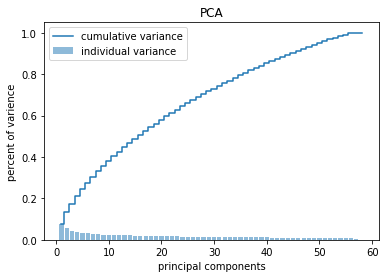

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(df_normalized)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(1,df_normalized.shape[0]+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual variance')
plt.step(range(1,df_normalized.shape[0]+1), cum_var_exp, where='mid', label='cumulative variance')
plt.ylabel('percent of varience')
plt.xlabel('principal components')
plt.legend(loc='best')
plt.title('PCA')
plt.show()

The analysis of the main components did not give any results, since the entire dispersion is described by 60 components

### Group the days in the hospital and apply other dimensional reduction methods such as UMAP, ISOMAP, MDS and TNSE with PCA

We divide patients into 3 groups:
1. less than 10 days in the hospital
2. in the hospital from 10 to 12 days
3. the hospital has more than 12 days

In [10]:
df['days_groups'] = 2
indexes = df[df['number of days']<=9].index
df.loc[indexes, 'days_groups'] = 1
indexes = df[df['number of days']>=13].index
df.loc[indexes, 'days_groups'] = 3
days_groups = df['days_groups'].values
colors = len(set(days_groups))

Function for drawing plots

In [11]:
def draw_plot(fit, title, n, ax_list, data=df_normalized):
    results = fit.fit_transform(data);
    
    subset = pd.DataFrame()
    subset['one'] = results[:,0]
    subset['two'] = results[:,1]
    
    ax = plt.subplot(1, 5, n)
    ax_list.append(ax)
    sns.scatterplot(
    x="one", y="two",
    hue=days_groups,
    palette=sns.color_palette("muted", colors),
    data=subset,
    legend='brief',
    alpha=1,
    ax=ax_list[n-1]
    )
    
    for i in range(results.shape[0]):
        plt.annotate(i, xy=(results[i,0], results[i,1]))
    
    plt.title(title, fontsize=18)

Thus, to reduce the dimension, it is necessary to use other methods of reducing the dimension, such as UMAP, Isomap, MDS, and TNSE. 

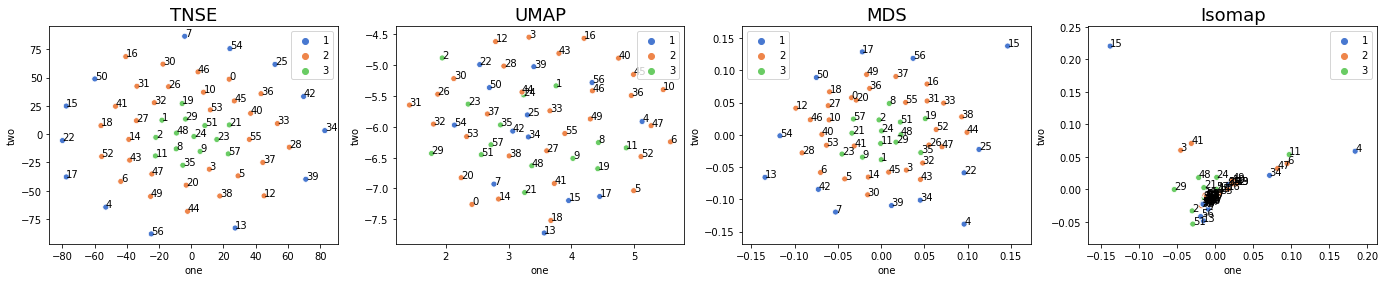

In [12]:
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
import umap #pip(conda) install umap-learn

names = ["TNSE", "UMAP", "MDS", "Isomap"]

methods = [
    TSNE(n_components=2),
    umap.UMAP(),
    MDS(n_components=2),
    Isomap(n_components=2)]

ax_list = []
plt.figure(figsize=(30,4))

for i in range(1,len(methods)+1):
    draw_plot(methods[i-1], names[i-1], i, ax_list)

As can be seen from the graphs in figure, the UMAP and Isomap methods reduce the dimension in such a way that it is impossible to separate one group of patients from another. Using the MDS and TNSE methods, the following relationship was found: the longer the patient received treatment, the closer to the center he is on the chart.

### Select isomap parameters

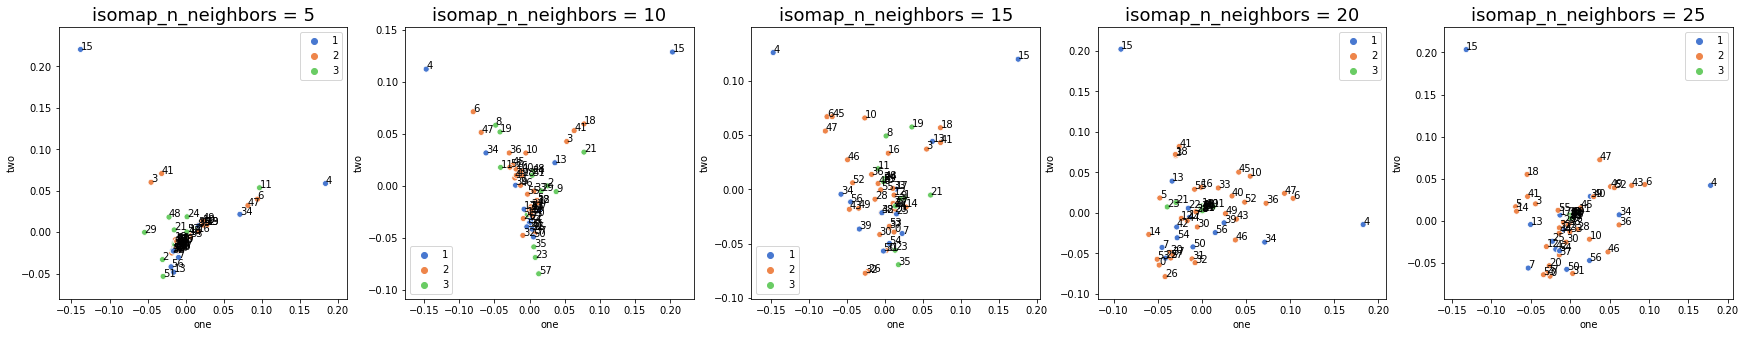

In [13]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = Isomap(
        n_neighbors=n*5,
        n_components=2)
    title='isomap_n_neighbors = {}'.format(n*5)
    draw_plot(fit, title, n, ax_list)

In the Isomap method, almost all parameters are automatically selected, and the n_neighbors parameter, which determines the number of neighbors, has the greatest impact. Therefore, this algorithm was applied with various n_neighbors values.
As can be seen from figure, for different values of n_neighbors it is still impossible to separate patient groups from each other. Thus, it is impossible to use this method to solve the problem.


### Select UMAP parameters

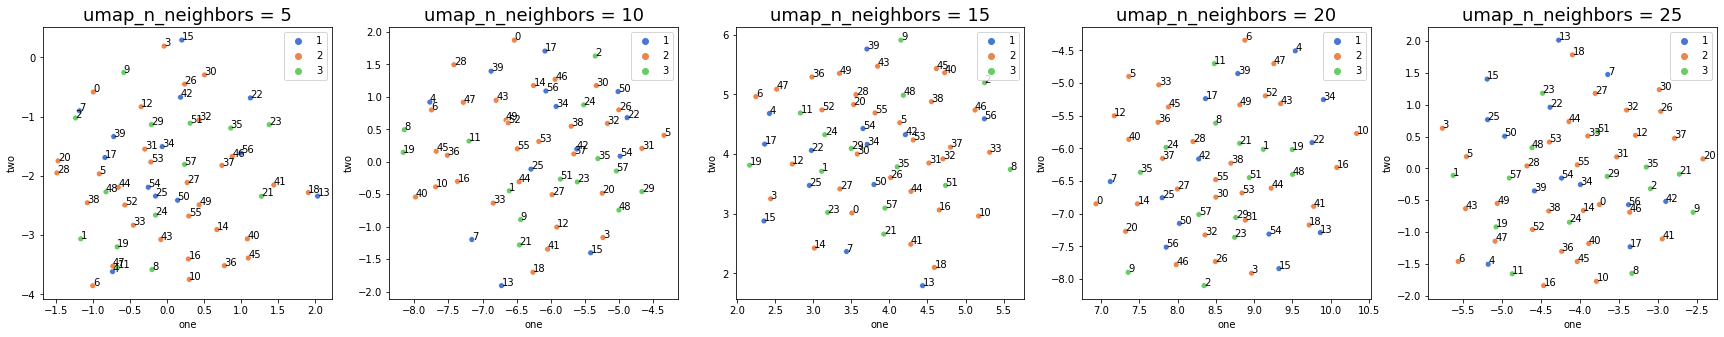

In [14]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = umap.UMAP(
        n_neighbors=n*5,
        n_components=2)
    title='umap_n_neighbors = {}'.format(n*5)
    draw_plot(fit, title, n, ax_list)

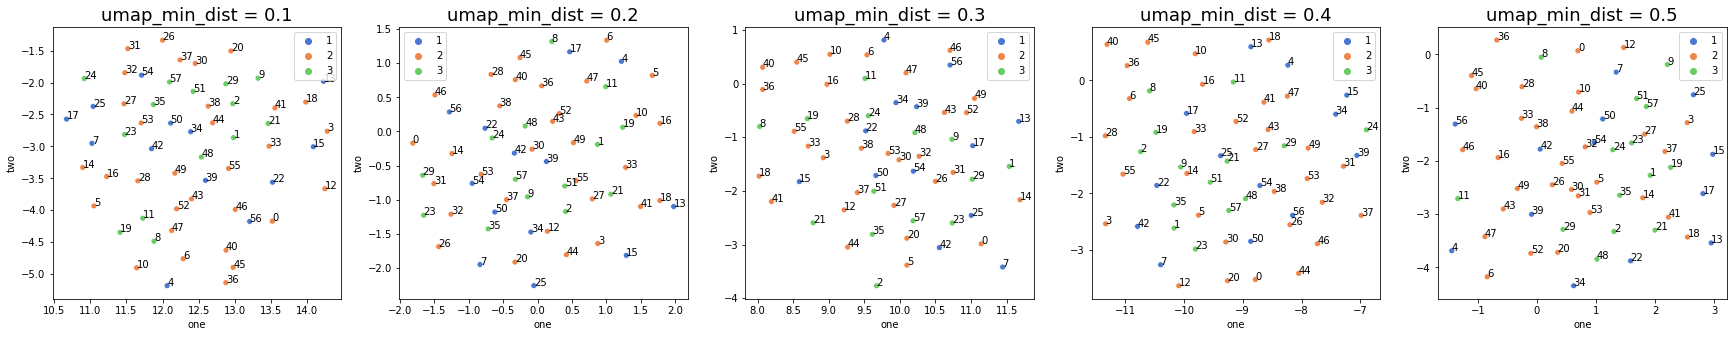

In [15]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = umap.UMAP(
        min_dist=n/10,
        n_components=2)
    title='umap_min_dist = {}'.format(n/10)
    draw_plot(fit, title, n, ax_list)

In the UMAP method, the parameters n_neighbors, which determines the number of neighbors, and min_dist, which determines the minimum allowable distance between points, have the greatest impact. Therefore, this algorithm was applied with different values of n_neighbors and min_dist.
As can be seen from figures 5, for different values of n_neighbors and min_dist it is still impossible to separate the patient groups from each other. Thus, it is impossible to apply this method to solve the problem.

### Select TNSE parameters

In the TNSE method, the perplexity parameters, which determines the number of nearest neighbors that is used in other manifold learning algorithms, and n_iter, which determines the number of iterations, have the greatest impact. Therefore, this algorithm was applied with different values of perplexity and n_iter.

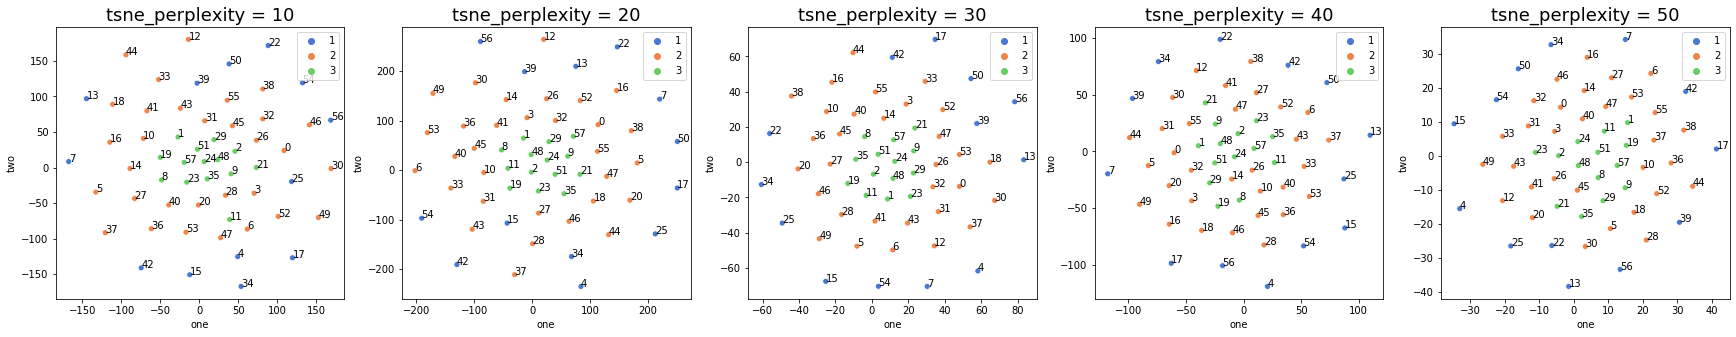

In [16]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = TSNE(
        perplexity=n*10,
        n_components=2)
    title='tsne_perplexity = {}'.format(n*10)
    draw_plot(fit, title, n, ax_list)

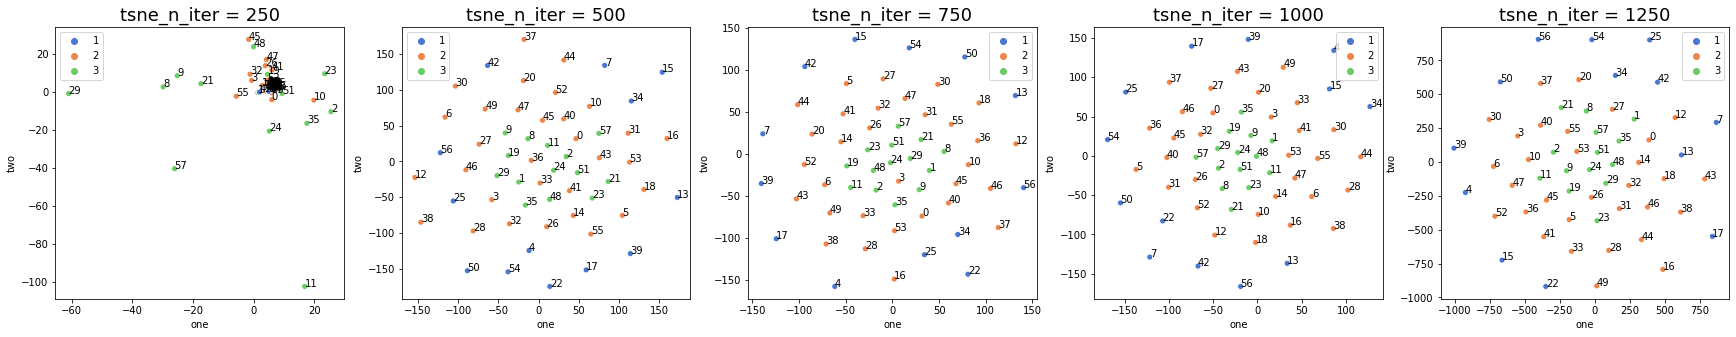

In [17]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = TSNE(
        n_iter=n*250,
        n_components=2)
    title='tsne_n_iter = {}'.format(n*250)
    draw_plot(fit, title, n, ax_list)

As can be seen from figures, the best separation of patient groups from each other is achieved with the values of perplexity = 30 and n_iter = 1000. These values correspond to the default settings.

### Select MDS parameters

In the MDS method, the metric parameters, which determines whether to use the metric or non-metric version of the algorithm, and max_iter, which determines the number of iterations, have the greatest impact. Therefore, this algorithm was applied with different metric and max_iter values.

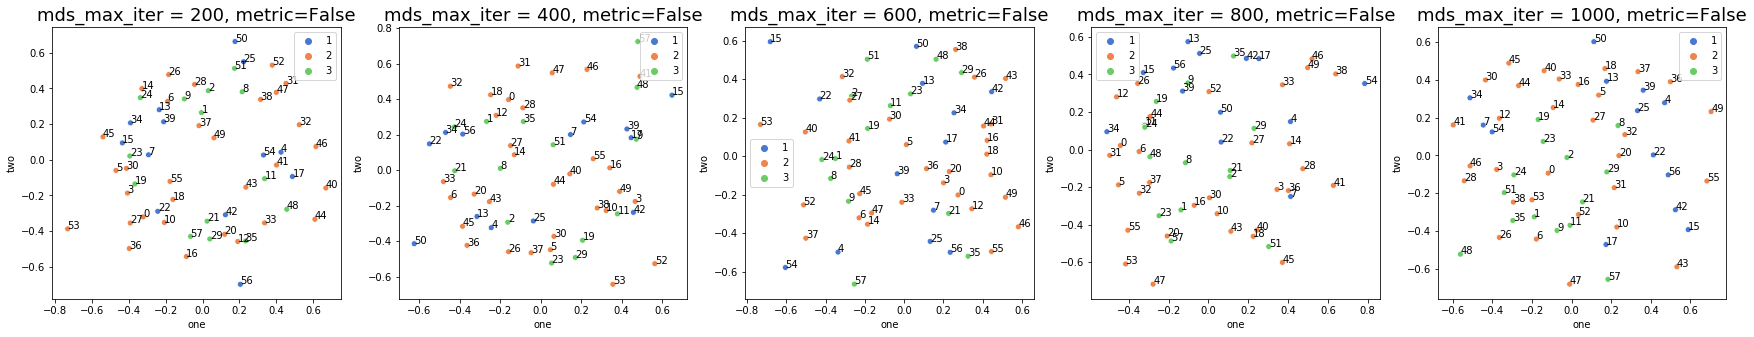

In [18]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = MDS(
        metric=False,
        max_iter=n*200,
        n_components=2)
    title='mds_max_iter = {}, metric={}'.format(n*200,False)
    draw_plot(fit, title, n, ax_list)

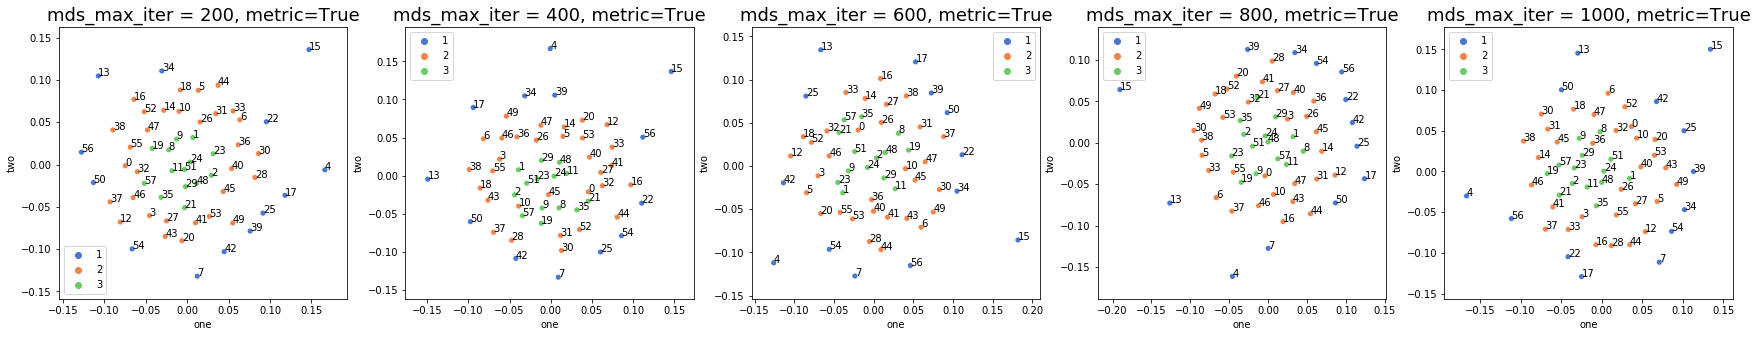

In [19]:
ax_list = []
plt.figure(figsize=(30,5))
for n in range(1,6):
    fit = MDS(
        metric=True,
        max_iter=n*200,
        n_components=2)
    title='mds_max_iter = {}, metric={}'.format(n*200,True)
    draw_plot(fit, title, n, ax_list)

As can be seen from figures, the best separation of patient groups from each other is achieved by metric MDS with the parameter value max_iter = 600. You can also notice that when using non-metric MDS, it is not possible to separate patient groups from each other.

Thus, various methods of reducing the dimension were applied at different parameter values, however, it was possible to separate the various groups of patients on the graph only using the MDS and TNSE methods. From these two methods, TNSE with standard parameters showed the best separation, so it will be used in future work.


### Classifiers

After the dimensionality reduction was made, it was necessary to apply a classifier in order to separate the groups of patients from each other.

First of all, the Nearest Neighbors, Linear SVM, RBF SVM, Gaussian Process, Decision Tree, Random Forest, Neural Net, AdaBoost, Naive Bayes, QDA classifiers were used on the entire data set:

In [20]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_normalized)

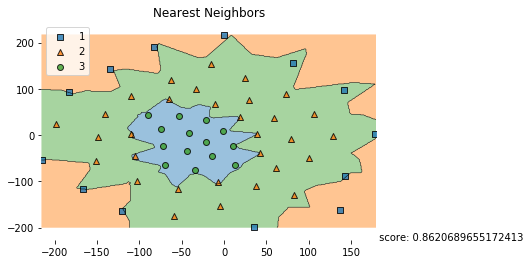

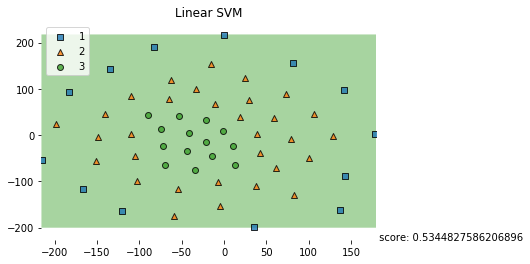

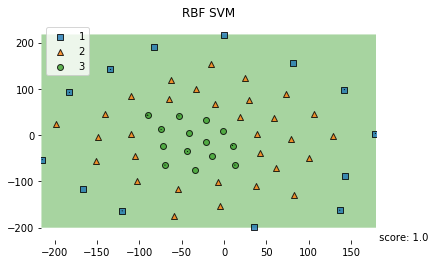

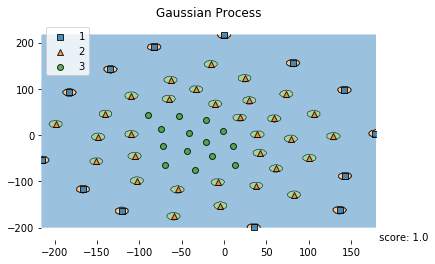

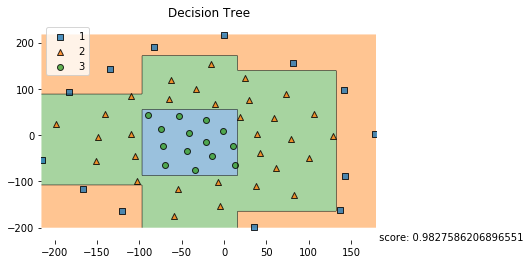

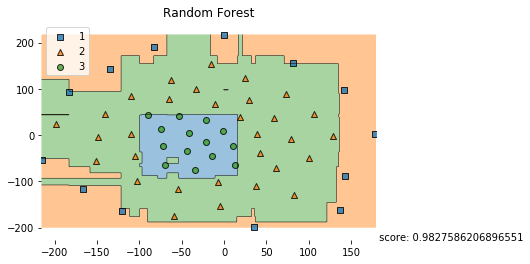

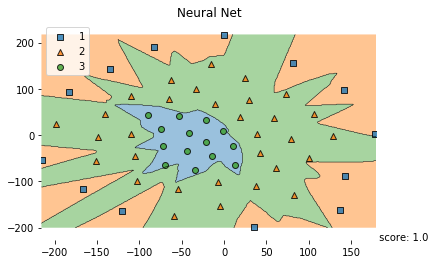

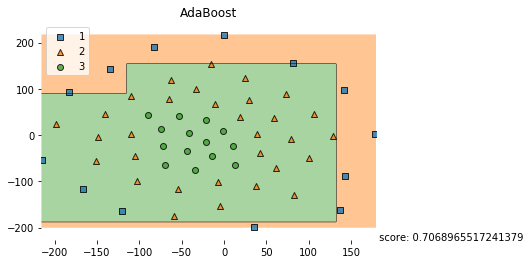

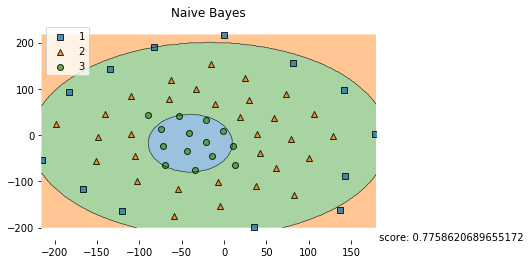

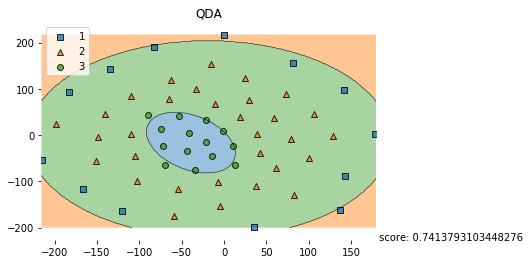

In [21]:
"""Classification on all data"""
#pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(tsne_results, days_groups)
    score = classifier.score(tsne_results, days_groups)
    
    plot_decision_regions(tsne_results, np.asarray(days_groups), clf=classifier, legend=2)
    plt.legend(loc='upper left')
    plt.title(names[i])
    plt.text(plt.xlim()[1], plt.ylim()[0],' score: '+str(score))
    plt.show()

The QDA classifier, showed the best accuracy with the preservation of the distribution form and without overfitting.

After that, the data set was divided into test and training samples. Then reclassification was performed:

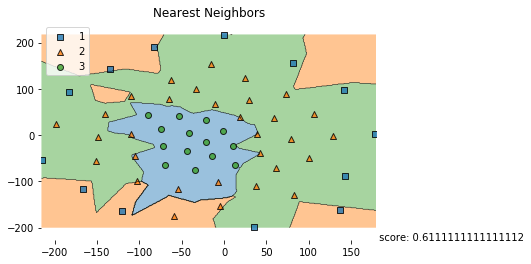

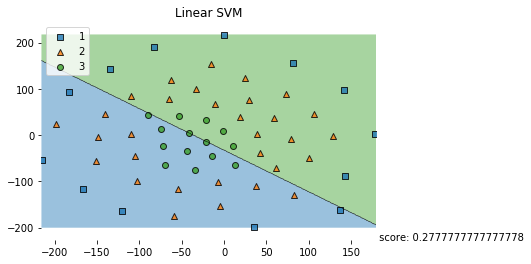

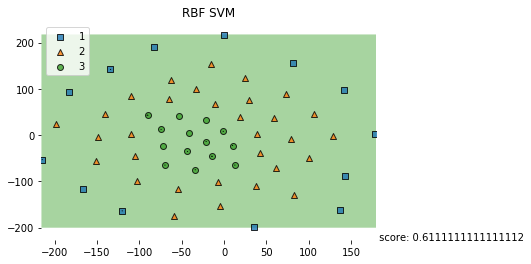

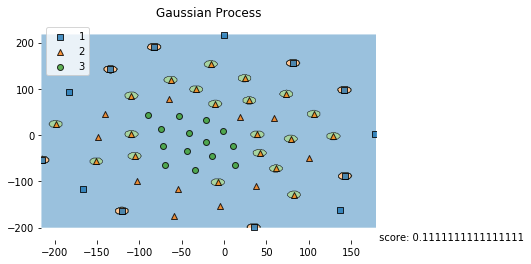

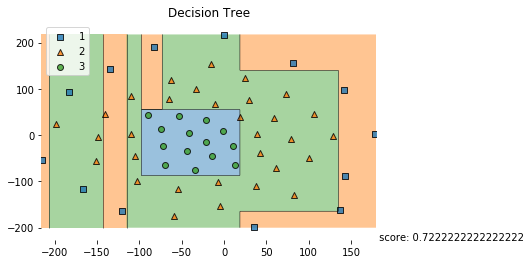

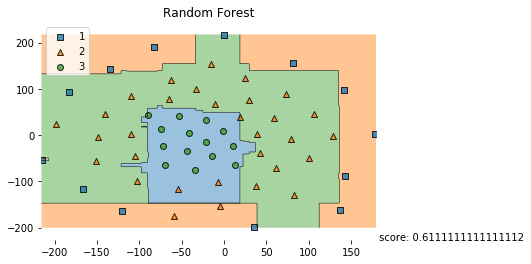

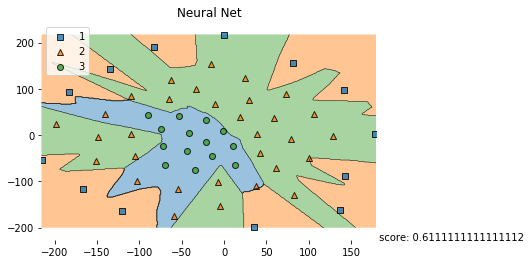

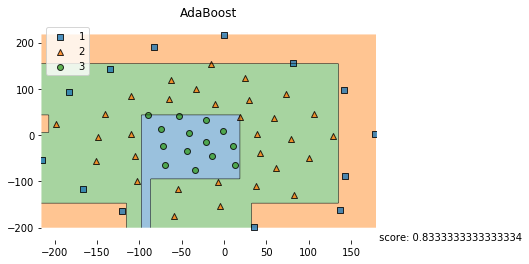

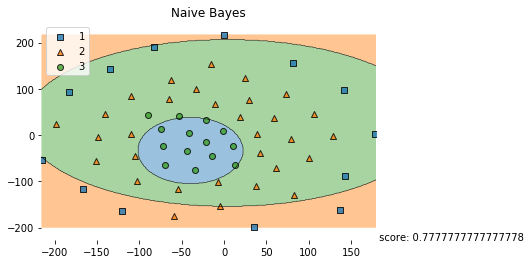

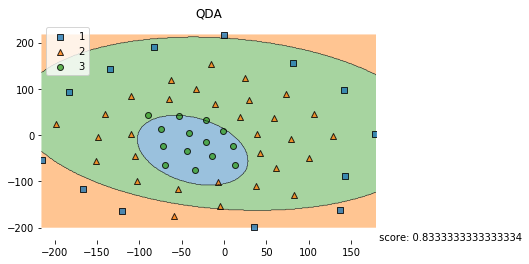

In [22]:
"""Classification on test data"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tsne_results, days_groups, test_size=.3, random_state=42)

for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)

    plot_decision_regions(tsne_results, np.asarray(days_groups), clf=classifier, legend=2)
    plt.legend(loc='upper left')
    plt.title(names[i])
    plt.text(plt.xlim()[1], plt.ylim()[0],' score: '+str(score))
    plt.show()

The decrease in accuracy and overfitting is conected with a small amount of data, since the sample size is only 58 patients.

Thus, patients were classified according to the length of hospital stay. In the problem of reducing dimensionality, the TSNE method showed the best result, and in the classification problem, the QDA method. The dependence was found: the longer the patient was in the hospital, the closer he was to the center on the chart. In the future, when such indicators as pressure, temperature and complaints, ellipses that divide the distributions into 3 groups will be used to evaluate the effectiveness of treatment, they will be divided into different sectors depending on medical indicators.

### Inspection of groups

Let's find out the most important words for each group.

In [23]:
long_treatment = [lines[i] for i in df[df['days_groups']==3].index]
med_treatment = [lines[i] for i in df[df['days_groups']==2].index]
fast_treatment = [lines[i] for i in df[df['days_groups']==1].index]

In [24]:
vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,3))
matrix = vectorizer.fit_transform(long_treatment).toarray()
df_long = pd.DataFrame(data=matrix)
df_long.columns = vectorizer.get_feature_names()

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,3))
matrix = vectorizer.fit_transform(med_treatment).toarray()
df_med = pd.DataFrame(data=matrix)
df_med.columns = vectorizer.get_feature_names()

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,3))
matrix = vectorizer.fit_transform(fast_treatment).toarray()
df_fast = pd.DataFrame(data=matrix)
df_fast.columns = vectorizer.get_feature_names()

In [25]:
df_long.sum(axis = 0).sort_values(ascending=False)[:20]

левый                   1.243414
голень                  0.941549
правый                  0.916028
кожа                    0.856471
гиперемия               0.801197
эритема                 0.742155
боль                    0.650388
отечь                   0.582015
поверхность             0.547302
левый голень            0.527433
шелушение               0.483499
стопа                   0.467807
эритема угасла          0.458819
голени                  0.453803
передний                0.439577
передний поверхность    0.433856
пигментация             0.422213
ощупь                   0.419084
правый голень           0.402325
левый голени            0.381105
dtype: float64

In [26]:
df_med.sum(axis = 0).sort_values(ascending=False)[:20]

правый            2.521754
голень            1.758128
кожа              1.725031
левый             1.531857
эритема           1.471688
гиперемия         1.450123
отечь             1.241776
жалоба            1.124126
кожа правый       1.040234
левый голень      1.021089
боль              0.996189
правый голень     0.895398
голени            0.891609
плечо             0.884136
голень эритема    0.799702
область           0.787341
состояние         0.763153
правый плечо      0.745949
правый голени     0.730092
сохраняться       0.728818
dtype: float64

In [27]:
df_fast.sum(axis = 0).sort_values(ascending=False)[:20]

левый               1.166773
правый              0.792196
кожа                0.784498
гиперемия           0.683521
кожа левый          0.651720
голень              0.616202
плечо               0.575563
отечь               0.574526
левый голень        0.546405
предплечье          0.502989
температура         0.494521
сохраняться         0.474706
левый плечо         0.467758
плечо предплечье    0.464098
болезненность       0.453638
область             0.439338
явление             0.420360
эритема             0.406471
местный             0.392764
кожи                0.389328
dtype: float64

Thus, we can see that the most important words for each group are almost the same.